In [33]:
import pandas as pd

import matplotlib.pyplot as plt

import numpy as np



import tensorflow as tf

import keras

from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential

from keras.layers import LSTM, Dense, Dropout

from sklearn.metrics import mean_squared_error

from keras.optimizers import Adam

from keras.callbacks import ReduceLROnPlateau

from keras.callbacks import EarlyStopping

In [34]:
pwd

'/kaggle/working'

In [35]:
df = pd.read_csv('/kaggle/input/energy/2yrs_data.csv') 

In [36]:
df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'])

df = df.sort_values('Datetime')

data = df['Global_active_power'].values.reshape(-1, 1)

In [37]:
scaler = MinMaxScaler(feature_range=(0, 1))

data_scaled = scaler.fit_transform(data)

In [38]:
class MultiStepTimeSeriesGenerator():

    """

    Copied and edited from https://www.tensorflow.org/tutorials/structured_data/time_series

    """



    def __init__(self,

                 input_width,

                 label_width,

                 shift,

                 df,

                 batch_size,

                 train_ratio=0.6,

                 val_ratio=0.2):



        # Ensure ratios add up to 1

        assert train_ratio + val_ratio < 1.0, "Train and val ratios must sum to less than 1.0 (leave space for test)."



        # Work out the window parameters

        self.input_width       = input_width

        self.label_width       = label_width

        self.shift             = shift

        self.batch_size        = batch_size

        self.total_window_size = input_width + label_width

        self.input_slice       = slice(0, input_width)

        self.labels_slice      = slice(self.total_window_size - self.label_width, None)



        # Calculate dataset split indices

        total_data = len(df) - (input_width + label_width)

        train_end = int(total_data * train_ratio)

        val_end = train_end + int(total_data * val_ratio)



        # Split the data

        self.train_df = df[:train_end]

        self.val_df = df[train_end:val_end]

        self.test_df = df[val_end:]



        # Create datasets

        self.train = self.make_dataset(self.train_df)

        self.val = self.make_dataset(self.val_df)

        self.test = self.make_dataset(self.test_df)



    def split_window(self, features):

        inputs = features[:, self.input_slice, :]

        labels = features[:, self.labels_slice, :]



        labels = tf.stack([labels[:, :, 0]], axis=-1)



        # Slicing doesn't preserve static shape information, so set the shapes manually

        inputs.set_shape([None, self.input_width, None])

        labels.set_shape([None, self.label_width, None])



        return inputs, labels



    def make_dataset(self, data):

        data = np.array(data, dtype=np.float32)

        ds = tf.keras.utils.timeseries_dataset_from_array(data=data,

                                                          targets=None,

                                                          sequence_length=self.total_window_size,

                                                          sequence_stride=1,

                                                          shuffle=False,

                                                          batch_size=self.batch_size)



        ds = ds.map(self.split_window)



        return ds

In [39]:
N_STEPS_IN = 24

N_STEPS_OUT = 12

N_EPOCHS = 10

BATCH_SIZE = 64

time_series_dataset = MultiStepTimeSeriesGenerator(input_width=N_STEPS_IN,

                                         label_width=N_STEPS_OUT,

                                         shift=12,

                                         df=data_scaled,

                                         batch_size=BATCH_SIZE,

                                         train_ratio=0.6,

                                         val_ratio=0.2)



# Access datasets

train_data = time_series_dataset.train

val_data = time_series_dataset.val

test_data = time_series_dataset.test



# Print dataset info

print(f"Train size: {len(time_series_dataset.train_df)}")

print(f"Validation size: {len(time_series_dataset.val_df)}")

print(f"Test size: {len(time_series_dataset.test_df)}")

Train size: 642318
Validation size: 214106
Test size: 214142


In [40]:
model = Sequential([

    LSTM(128, activation='relu', return_sequences=True, input_shape=(N_STEPS_IN, 1)),

    Dropout(0.3),

    LSTM(64, activation='relu', return_sequences=True),

    Dropout(0.2),

    LSTM(32, activation='relu'),

    Dropout(0.2),

    Dense(N_STEPS_OUT)

])



# Compile model

optimizer = Adam(learning_rate=0.001, clipnorm=1.0)  # Clip gradients

model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])



# Create datasets from dataframe

time_series_dataset = MultiStepTimeSeriesGenerator(input_width=N_STEPS_IN,

                                         label_width=N_STEPS_OUT,

                                         shift=12,

                                         df=data_scaled,

                                         batch_size=BATCH_SIZE,

                                         train_ratio=0.6,

                                         val_ratio=0.2)



reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-6)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)



# Train model

history = model.fit(

    time_series_dataset.train,

    validation_data=time_series_dataset.val,

    epochs=10,

    verbose=1,

    callbacks=[early_stopping, reduce_lr],  # Combine EarlyStopping and ReduceLROnPlateau

    shuffle=False

)



# Evaluate the model on the test set

test_predictions = model.predict(time_series_dataset.test, verbose=0)



# Prepare the test labels

test_labels = np.concatenate(

    [batch[1] for batch in time_series_dataset.test.as_numpy_iterator()], axis=0

)



# Reshape predictions if necessary

test_predictions = np.squeeze(test_predictions)

test_labels = np.squeeze(test_labels)



# Calculate the test Mean Squared Error

test_mse = mean_squared_error(test_labels, test_predictions)

test_mse = np.round(test_mse, 5)



print(f"Test Mean Squared Error: {test_mse}")


Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


10036/10036 ━━━━━━━━━━━━━━━━━━━━ 108s 10ms/step - loss: 0.0059 - mae: 0.0460 - val_loss: 0.0029 - val_mae: 0.0285 - learning_rate: 0.0010
Epoch 2/10
10036/10036 ━━━━━━━━━━━━━━━━━━━━ 92s 9ms/step - loss: 0.0038 - mae: 0.0356 - val_loss: 0.0029 - val_mae: 0.0306 - learning_rate: 0.0010
Epoch 3/10
10036/10036 ━━━━━━━━━━━━━━━━━━━━ 92s 9ms/step - loss: 0.0037 - mae: 0.0347 - val_loss: 0.0029 - val_mae: 0.0307 - learning_rate: 0.0010
Epoch 4/10
10036/10036 ━━━━━━━━━━━━━━━━━━━━ 92s 9ms/step - loss: 0.0036 - mae: 0.0342 - val_loss: 0.0029 - val_mae: 0.0310 - learning_rate: 0.0010
Epoch 5/10
10036/10036 ━━━━━━━━━━━━━━━━━━━━ 91s 9ms/step - loss: 0.0036 - mae: 0.0339 - val_loss: 0.0028 - val_mae: 0.0305 - learning_rate: 0.0010
Epoch 6/10
10036/10036 ━━━━━━━━━━━━━━━━━━━━ 93s 9ms/step - loss: 0.0035 - mae: 0.0335 - val_loss: 0.0028 - val_mae: 0.0307 - learning_rate: 0.0010
Epoch 7/10
10036/10036 ━━━━━━━━━━━━━━━━━━━━ 92s 9ms/step - loss: 0.0034 - mae: 0.0327 - val_loss: 0.0028 - val_mae: 0.0299 - le

In [41]:
mape = np.mean(np.abs((test_labels - test_predictions) / test_labels)) * 100

print(f"Test MAPE: {mape:.2f}%")



from sklearn.metrics import r2_score

r2 = r2_score(test_labels, test_predictions)

print(f"R² Score: {r2:.5f}")



test_mse = mean_squared_error(test_labels, test_predictions)

print(f"Test MSE: {test_mse:.5f}")

Test MAPE: inf%
R² Score: 0.76550
Test MSE: 0.00235


/tmp/ipykernel_23/2171864488.py:1: RuntimeWarning: divide by zero encountered in divide
  mape = np.mean(np.abs((test_labels - test_predictions) / test_labels)) * 100


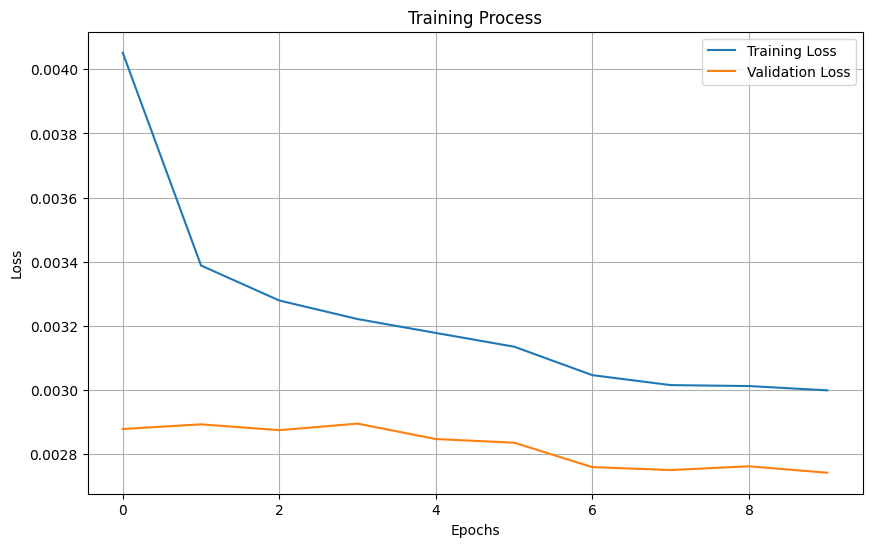

In [42]:
# Extract training and validation loss

loss = history.history['loss']

val_loss = history.history['val_loss']



# Plot the losses

plt.figure(figsize=(10, 6))

plt.plot(loss, label='Training Loss')

plt.plot(val_loss, label='Validation Loss')

plt.title('Training Process')

plt.xlabel('Epochs')

plt.ylabel('Loss')

plt.legend()

plt.grid(True)

plt.show()


In [43]:
#model.save('lstm_model.pth')

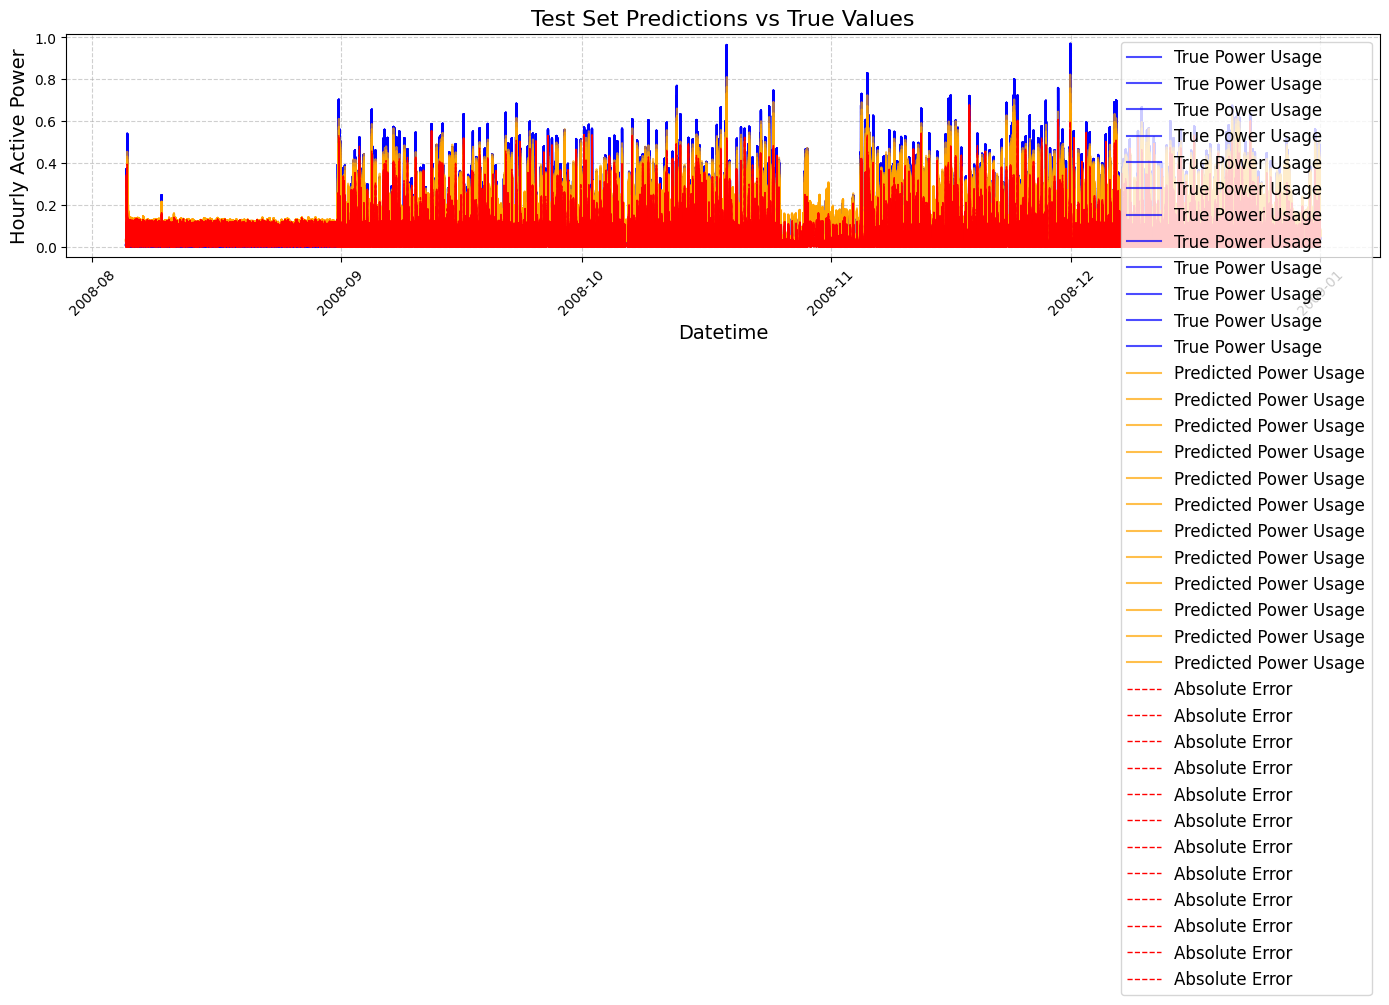

In [44]:
absolute_error = np.abs(test_labels - test_predictions)



datetime_test = df['Datetime'][-len(test_labels):]

plt.figure(figsize=(14, 7))

plt.plot(datetime_test, test_labels, label='True Power Usage', color='blue', linewidth=1.5, alpha=0.7)

plt.plot(datetime_test, test_predictions, label='Predicted Power Usage', color='orange', linewidth=1.5, alpha=0.7)

plt.plot(datetime_test, absolute_error, label='Absolute Error', color='red', linestyle='--', linewidth=1)



# Add labels, title, legend, and grid

plt.title('Test Set Predictions vs True Values', fontsize=16)

plt.xlabel('Datetime', fontsize=14)

plt.ylabel('Hourly Active Power', fontsize=14)

plt.legend(fontsize=12, loc='upper right')  # Ensure a single legend with proper placement

plt.grid(True, linestyle='--', alpha=0.6)

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()

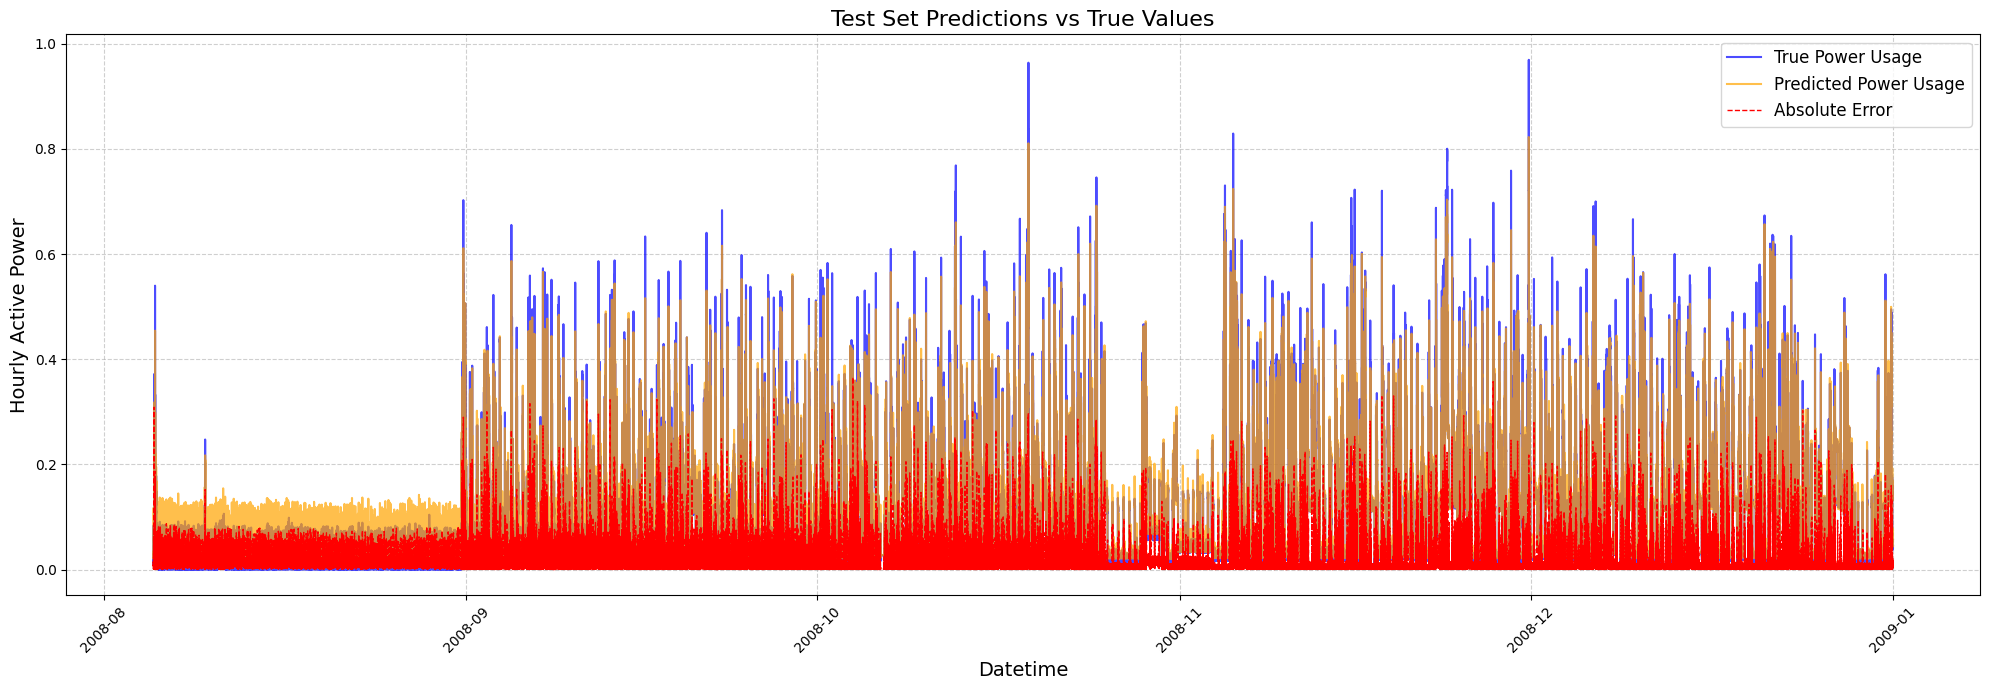

In [45]:
test_labels_1d = test_labels[:, 0]  # Select the first timestep from each sequence

test_predictions_1d = test_predictions[:, 0]



# Assuming test_labels_1d, test_predictions_1d, and datetime_test are defined

absolute_error = np.abs(test_labels_1d - test_predictions_1d)



plt.figure(figsize=(20, 7))



# Plot each data type

line1, = plt.plot(datetime_test, test_labels_1d, label='True Power Usage', color='blue', linewidth=1.5, alpha=0.7)

line2, = plt.plot(datetime_test, test_predictions_1d, label='Predicted Power Usage', color='orange', linewidth=1.5, alpha=0.7)

line3, = plt.plot(datetime_test, absolute_error, label='Absolute Error', color='red', linestyle='--', linewidth=1)



# Add a single legend

plt.legend(handles=[line1, line2, line3], fontsize=12, loc='upper right')



# Add labels, title, and grid

plt.title('Test Set Predictions vs True Values', fontsize=16)

plt.xlabel('Datetime', fontsize=14)

plt.ylabel('Hourly Active Power', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.6)

plt.xticks(rotation=45)

plt.tight_layout()

plt.show()
